# Scaling Analysis and Modeling

In this chapter the question of how calibration time $T$ scale with the number of available processing units (PUs) $n$ will be examined. It is possible to perform two types of scaling analyses, one where the _size of the problem_ stays fixed and one where it varies with the number of PUs. As customary, I will refer to them as **weak scaling** and **strong scaling** respectively. What do I mean by _size of the problem_ in the context of derivative-free optimization? One obvious answer is the number of function evaluations, or budget, in the parlance of the Nevergrad library; but this number is a random variable when we resample after failing computations. Nonetheless, the budget is the infimum for the actual number of function evaluations and `optimizer.tell` calls, which is the amount of information collected by the optimizer. Therefore, the budget is a good definition for the size of the problem after all, as long as one keeps in mind that he is dealing with a stochastic process. Indeed, each particular realization will not depend in a deterministic way on parameters such as the budget. However, changing the budget **will** change the distribution, and the mean value of calibration time in a deterministic way.

For evolutionary algorithms the budget is given by the number of individuals $p$ times the number of generations $g$. For these algorithms, as more thoroughly explained in previous chapters, changing the population size can have large effects on the result and execution time of optimization. Indeed, the population size determines, on the one hand, the probability of escaping from a local minimum and, on the other, the degree to which optimization can be executed in parallel. The latter statement, for which we have developed an intuition based on the arguments in the previous chapters, will be given a quantitative form later on in this one. For the previous reasons, in the following I will consider $p$ as the size of the problem, and the number of generations $g$ fixed.

In [1]:
import scrapbook as sb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from datetime import timedelta
from mhpc_project.utils import get_scaling_data
from scipy.optimize import curve_fit

plt.rcParams.update({'figure.figsize':(16,9), 'figure.dpi':100})

## Scaling and Efficiency

### Strong Scaling

In this analysis, the calibration notebook has been executed several times with increasing $n$ while keeping $p$ fixed. This is done using Papermill, which allows parametrizing and executing Jupyter notebooks in an automated way. Later, using the Scrapbook library, it is possible to recover the objects defined during the execution (which are serialized and saved within the notebook) and the metadata saved by Papermill, such as the notebook execution time.

The Scrapbook library offers the convenience function `read_notebooks` that takes the path to a directory and returns a scrapbook. This object has an iterator interface that yields the notebooks within that directory, and that can be used to collect the data from an ensemble of notebooks.

In [2]:
strong_scaling_book = sb.read_notebooks('../runs/strong_scaling')

We can retrieve the data relevant to scaling using the `get_scaling_data` function from `mhpc_project.utils`. This function takes a scrapbook and for each of its notebooks checks that every code cell has been successfully executed and, if so, it stores its data in a Pandas dataframe.

In [3]:
strong_scaling_data =  get_scaling_data(strong_scaling_book)
strong_scaling_data.head()

,name,num_cpus,popsize,num_generations,ratio,duration,num_samples,samples_duration,num_good_samples,good_samples_duration,efficiency,speedup
0,testbed-NGO-4096-1024-6Cy,1024,512,8,0.5,1345.692414,4849,530615.400963,4100,418992.039157,0.304061,19.184729
1,testbed-NGO-4096-1024-RJ3,1024,512,8,0.5,1773.088293,4956,550710.424364,4096,423005.345256,0.232978,14.560327
2,testbed-NGO-4096-1024-WO3,1024,512,8,0.5,2044.776349,4922,543414.466632,4120,424187.515901,0.202587,12.625706
3,testbed-NGO-4096-1024-hNP,1024,512,8,0.5,1385.237619,4739,518288.827073,4097,424066.970334,0.298958,18.637051
4,testbed-NGO-4096-1024-jar,1024,512,8,0.5,2020.561965,4937,547096.831652,4098,423238.672021,0.204556,12.777012


As noted above, the calibration time is a random variable and, as shown by the entries in the previous dataframe, it can vary widely from one realization to another, although with the same parameters. However, we will be mainly concerned with its mean value $T$, and, if not explicitly stated otherwise, I will refer to mean values when talking about execution times (the same goes for its derived quantities).

The speedup $S$ is usually defined as

$$ S(n, p) = \frac{T(1, p)}{T(n, p)} \, .$$

However, since we don't have a serial execution as a reference, the following definition will be used

$$ S(n, p) = \frac{T(n_0, p)}{T(n, p)} \, ,$$

where in our case $n_0 = 32$. In case of perfect (linear) strong scaling, $T$ is inversely proportional to $n$, and we have

$$ S(n, p) = \frac{n}{n_0} \, .$$

It is possible to improve this simple model of the computation by including the effect of the population size. If the objective never fails, each PU exceeding the population size will idle. Hence, we can have perfect scaling only up to $n = p$

$$ S(n, p) = \frac{\min(n, p)}{n_0} \, . $$ (eq:max_speedup)

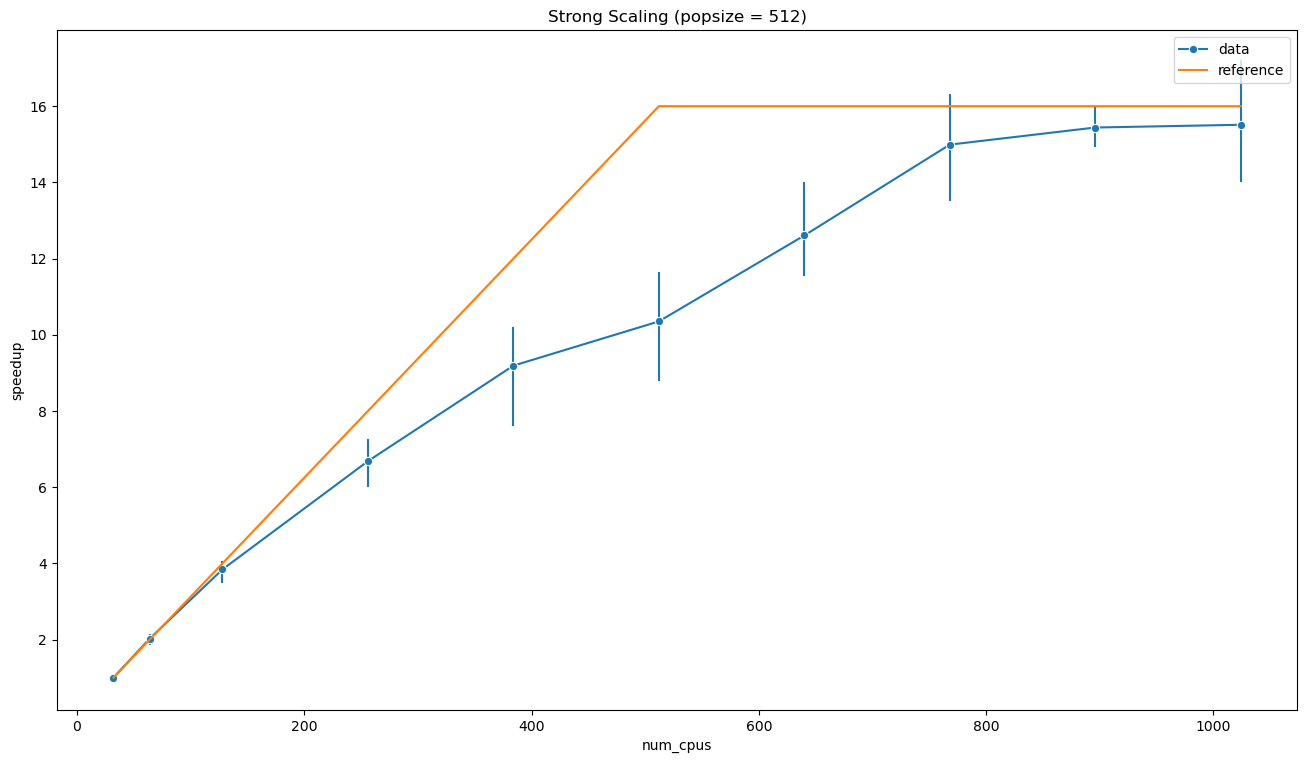

In [4]:
ax = sns.lineplot(data=strong_scaling_data, x='num_cpus', y='speedup',
             err_style='bars', marker='o', label='data')
sns.lineplot(x=strong_scaling_data['num_cpus'], y=strong_scaling_data[['num_cpus', 'popsize']].min(axis=1) / strong_scaling_data['num_cpus'].min(),
             label='reference', ax=ax)
ax.set_title('Strong Scaling (popsize = 512)')
plt.show()

As can be evinced from the plot above, the simple model described by the equation {eq}`eq:max_speedup} seems to be very effective. It is interesting to note that the execution appears to reach values near the theoretical maximum speedup, but with $n$ sensibly larger than $p$. One possible interpretation is that, as we know, the effective population size is larger than $p$ due to objective function failures. However, in that case the speedup should be also larger than $p / n_0$. In principle, knowing the statistics of the objective execution times and failures, it should be possible to model more accurately the calibration speedup. However, I will use a simpler approach based on data.

### Efficiency

Another interesting quantity is the efficiency, defined as the fraction of time spent by a PU computing the values of the objective actually told to the optimizer

$$ \eta(p, n) = \frac{\sum\limits_{X_i \text{ told}} t_i}{n T} \, .$$

By definition, the remaining part of time is spent idle, computing NaNs or unused values.

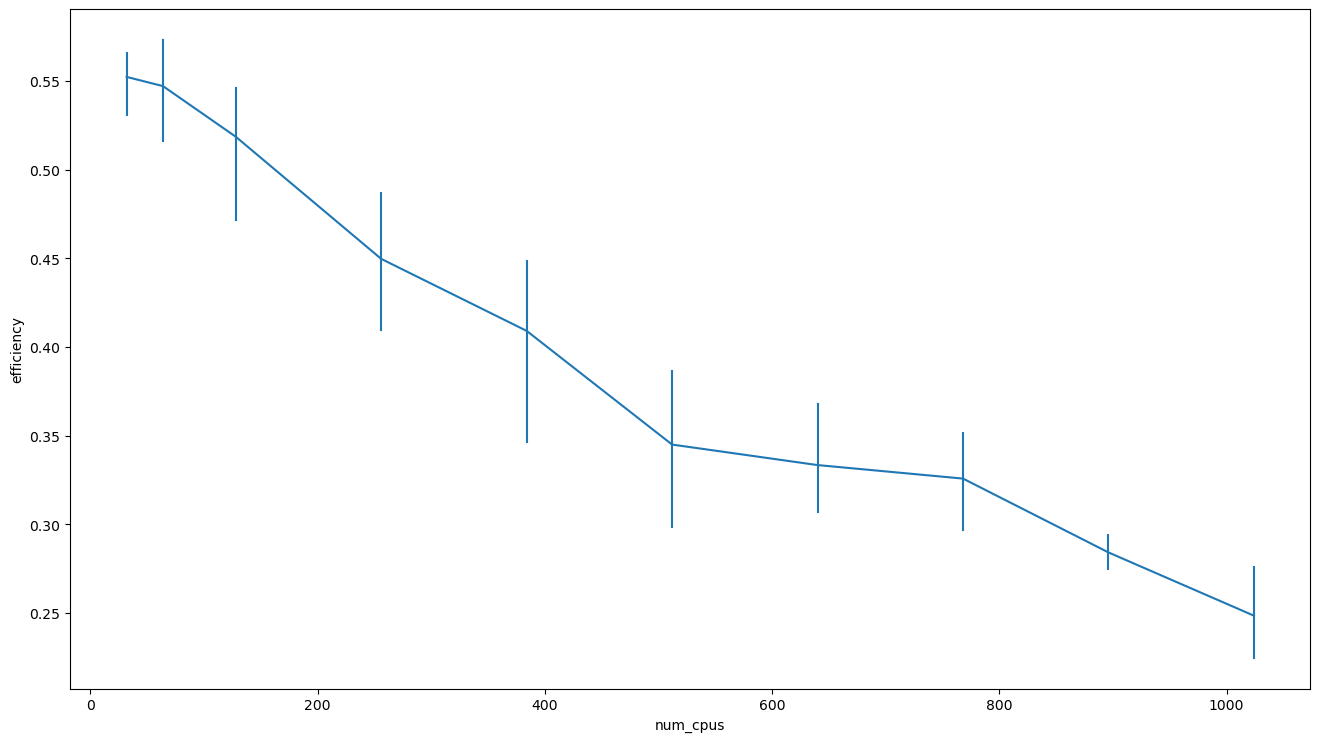

In [5]:
sns.lineplot(data=strong_scaling_data, x='num_cpus', y='efficiency', err_style='bars')
plt.show()

It is worth noting that while we can get a speedup by using more PUs, the efficiency will drop.

### Weak Scaling

In weak scaling analysis, the calibration notebook has been executed several times with increasing $p$ and $n$, while keeping the ration $p / n$ fixed. Note that from strong scaling analysis we know that larger $p / n$ values correspond to smaller errors.

In case of weak scaling, the speedup is not a meaningful metric, since the size of the problem changes. Instead, we are interested in the execution time $T$, and perfect scaling happens when $T$ is constant.

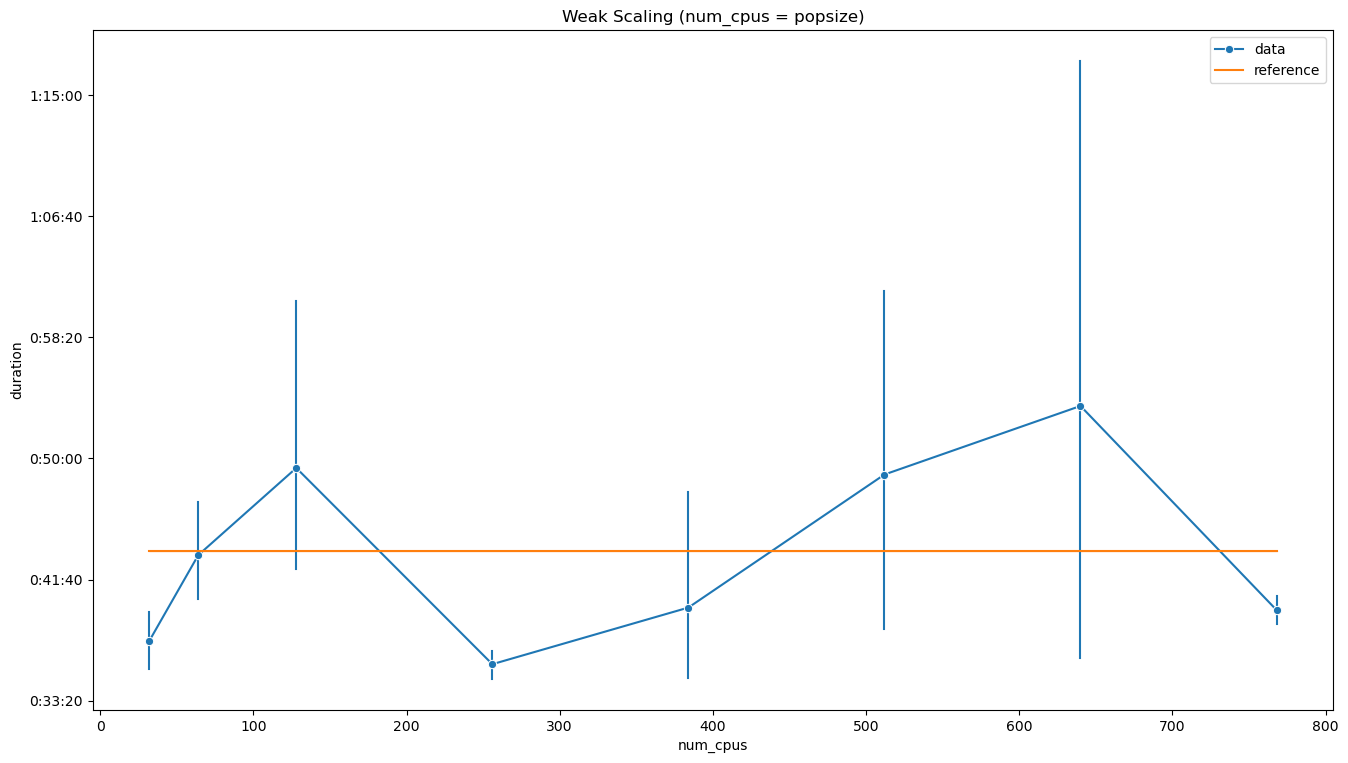

In [6]:
weak_scaling_book = sb.read_notebooks('../runs/weak_scaling')
weak_scaling_data = get_scaling_data(weak_scaling_book)
ax = sns.lineplot(data=weak_scaling_data, x='num_cpus', y='duration',
             label='data', err_style='bars', marker='o')
ax.yaxis.set_major_formatter(lambda value, position: timedelta(seconds=value))
sns.lineplot(x=weak_scaling_data['num_cpus'], y=weak_scaling_data['duration'].mean(),
             label='reference', ax=ax)
ax.set_title('Weak Scaling (num_cpus = popsize)')
plt.show()

In the plot above, the reference indicating perfect scaling is chosen as the average execution time, and visual inspection suggests that the hypothesis of perfect weak scaling is compatible with the data within the errors. The same thing can be shown by means of linear regression in the plot and summary below.

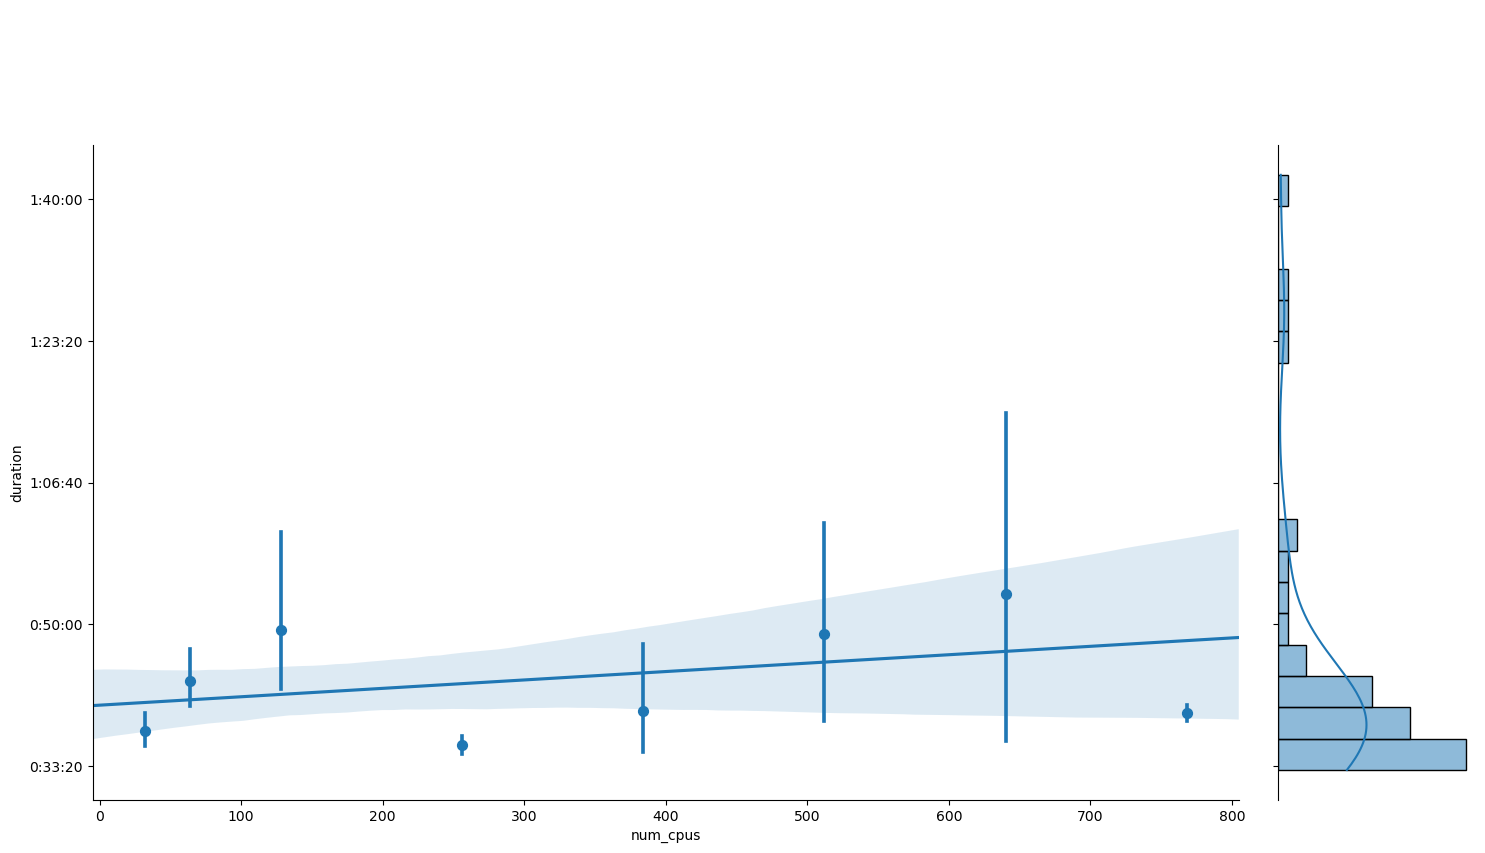

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               duration   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.525
Date:                Mon, 08 Feb 2021   Prob (F-statistic):              0.222
Time:                        09:17:17   Log-Likelihood:                -457.80
No. Observations:                  56   AIC:                             919.6
Df Residuals:                      54   BIC:                             923.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2428.8054    191.431     12.688      0.000    2045.010    2812.601
num_cpus       0.5934      0.481      1.235      0.222      -0.370       1.557
==============================================================================
Omnibus:                       42.536   Durbin-Watson:                   2.219
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.578
Skew:                           2.342   Prob(JB):                     1.32e-25
Kurtosis:                       8.212   Cond. No.                         652.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
grid = sns.JointGrid(data=weak_scaling_data, x='num_cpus', y='duration')
grid.fig.set_figwidth(16)
grid.fig.set_figheight(9)
grid.plot_joint(sns.regplot, x_estimator=np.mean, truncate=False)
grid.ax_marg_x.set_axis_off()
sns.histplot(data=weak_scaling_data, y='duration', kde=True, ax=grid.ax_marg_y)
grid.ax_joint.yaxis.set_major_formatter(lambda value, position: timedelta(seconds=value))
# plots.duration_regplot(weak_scaling_data)
plt.show()

smf.ols(formula='duration ~ 1 + num_cpus', data=weak_scaling_data).fit().summary()


## A Linear Model

Previous results make sense since, without further assumptions, neither perfect weak scaling imply perfect strong scaling (as would contradict our observations), nor vice-versa. Also, the way in which we measure the problem size affects weak scaling. Howeer, if the execution time is proportional to the problem size, then one form of scaling imply the other.

This fact is more evident in equations than words: the two contitions are

$$\begin{align} T(p, n) & \propto \frac{1}{n} & \text{for strong scaling} \\ T(p, n) &= T(\frac{p}{n}) & \text{for weak scaling} \end{align} \, $$

hence, if $T(p, n) \propto p$, then one imply the other.

More often, a sensible requirement on the size $p$ is just that $T(p, n) \sim \mathcal{O}(p)$. In this sense, choosing the population size $p$ as the problem size seems very reasonable. Indeed, it is plausible, as a first approximation, that the fraction of successful objective function calls stays constant as we change $p$: hence, the required amount of computation goes asymptotically as $p$.

What we can deduce from the previous analyses? From perfect weak scaling we know that $T$ is a function of $p / n$ alone. From strong scaling we know that the speedup for large $n$ seems to saturate at a non-zero value, which means that $T$ cannot have neither poles nor zeros for finite (of course, non-negative) $p / n$. Therefore, the simplest form for $T$ is a linear model

$$ T(p, n) = T_0 + T_1 \frac{p}{n} \, .$$ (eq:linear_model)

Let's see if this model fits the data and what can be deduced from it.

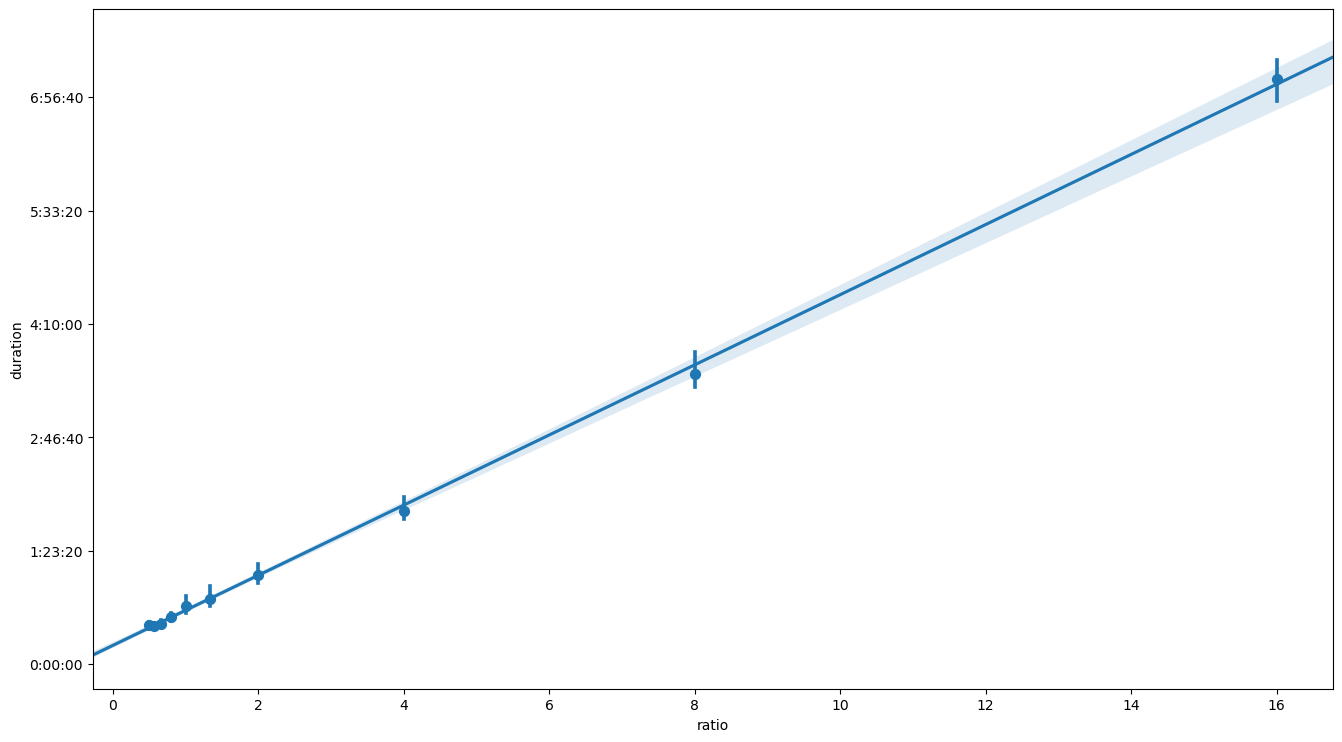

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               duration   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     8729.
Date:                Mon, 08 Feb 2021   Prob (F-statistic):           1.34e-59
Time:                        09:17:17   Log-Likelihood:                -406.38
No. Observations:                  54   AIC:                             816.8
Df Residuals:                      52   BIC:                             820.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    822.2863     73.346     11.211      0.000     675.106     969.467
ratio       1546.7021     16.554     93.431      0.000    1513.483    1579.921
==============================================================================
Omnibus:                        5.439   Durbin-Watson:                   2.198
Prob(Omnibus):                  0.066   Jarque-Bera (JB):                4.363
Skew:                           0.623   Prob(JB):                        0.113
Kurtosis:                       3.622   Cond. No.                         5.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
data = strong_scaling_data
ax = sns.regplot(data=strong_scaling_data, x='ratio', y='duration', x_estimator=np.mean, truncate=False)
ax.yaxis.set_major_formatter(lambda value, position: timedelta(seconds=value))
plt.show()

fit = smf.ols(formula='duration ~ 1 + ratio',data=data).fit()
fit.summary()

Linear regression of the optimization time $T$ gives a strong indication that equation {eq}`eq:linear_model` might be the right candidate. The same functional relation can be represented also in the scaling plot.

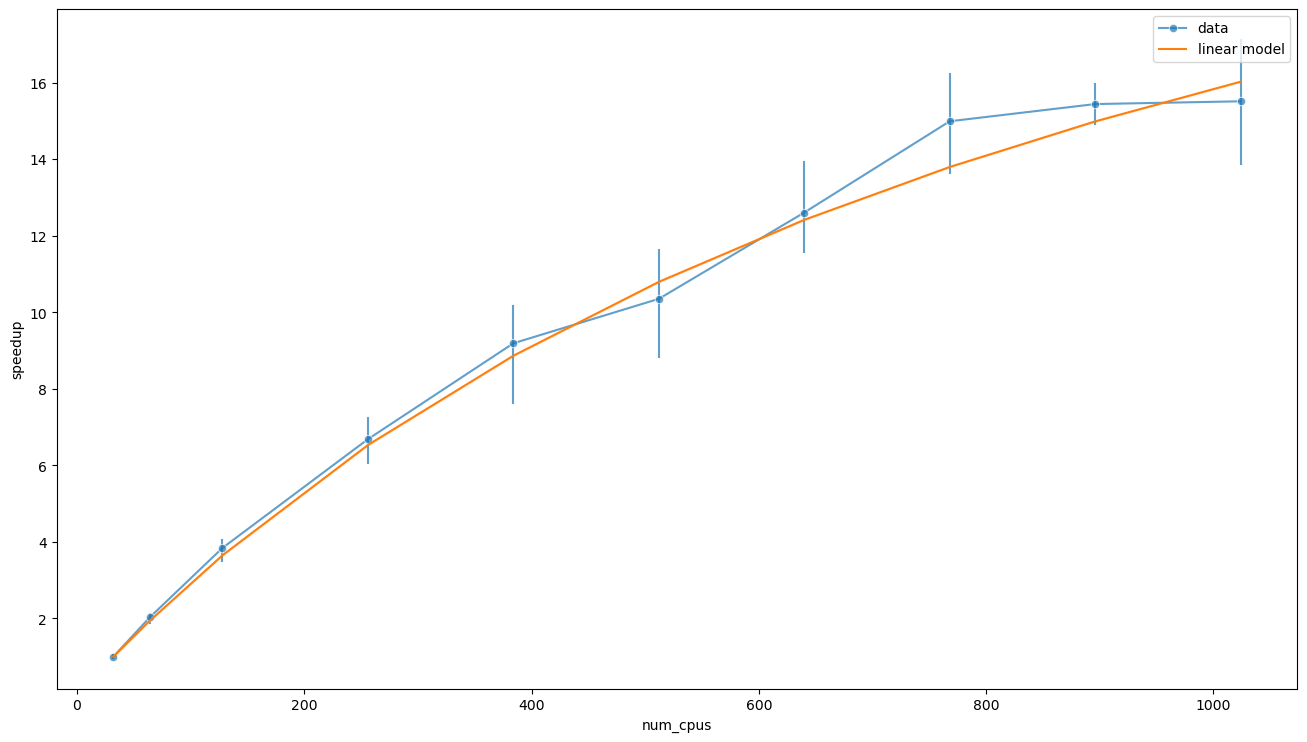

In [9]:
ys=(fit.params[0] + fit.params[1] * 512 / 32) / fit.predict(data['ratio'])
sns.lineplot(data=data, x='num_cpus', y='speedup', alpha=0.7, marker='o', err_style='bars', label='data')
sns.lineplot(x=data['num_cpus'], y=ys, label='linear model')
plt.show()

We can also explicitly calculate the speedup

$$ S(p, n) = \frac{T_0 + T_1 \frac{p}{n_0}}{T_0 + T_1 \frac{p}{n}} = \frac{1}{\frac{T_0}{T_0 + T_1 \frac{p}{n_0}} + \frac{T_1 \frac{p}{n_0}}{T_0 + T_1 \frac{p}{n_0}} \frac{n_0}{n}} \, , $$

and compare this expression with the Amdahl's law (corrected to use $T(p, n_0)$ as a reference)

$$ S(n) = \frac{1}{(1 - f) + f \frac{n_0}{n}} \, , $$

where $f$ is the fraction of the program that can benefit from the speedup.

Therefore, we have that

$$ f = \frac{T_1 \frac{p}{n_0}}{T_0 + T_1 \frac{p}{n_0}} \approx 96.8 \%$$

or, equivalently, that the fraction of time that the program spend in serial code (that is not split among PUs, i.e. the internals of the optimizer) is approximately the 3.2%. Note that this has nothing to do with the data dependency that exists between a generation of individuals and the next, which actually limits the possibility to scale the execution on larger numbers of PUs.

We can also calculate the maximum speedup

$$ S_\text{max} = \frac{1}{1 - f} = 1 + \frac{T_1}{T_0} \frac{p}{n_0} \approx 31 \, ,$$

which is sensibly higher than predicted using the simple model based on the assumption of perfect strong scaling up to $p$.

In this case, the previous argument would suggest an effective population size of $p_\text{eff} \approx n_0 S_\text{max} \approx 963$ individuals. The new estimate of $S_\text{max}$ is however too high, and the reason is that the linear model considered fails for small $p / n$, that is large $n$. We will address this issue later.

We can use the formula for $T$ also to express the efficiency. Since the number of `optimizer.tell` calls is approximately $p$, then, for large enough $p$, we can approximate the sum in the definition of $\eta$ as $g$ times $p$ times the mean execution time of successful computations $\langle t_\text{s} \rangle$

$$ \eta(p, n) = \frac{p}{n} \frac{g \langle t_\text{s} \rangle}{T} = \frac{g \langle t_\text{s} \rangle}{\frac{n}{p} T_0 + T_1} \, .$$


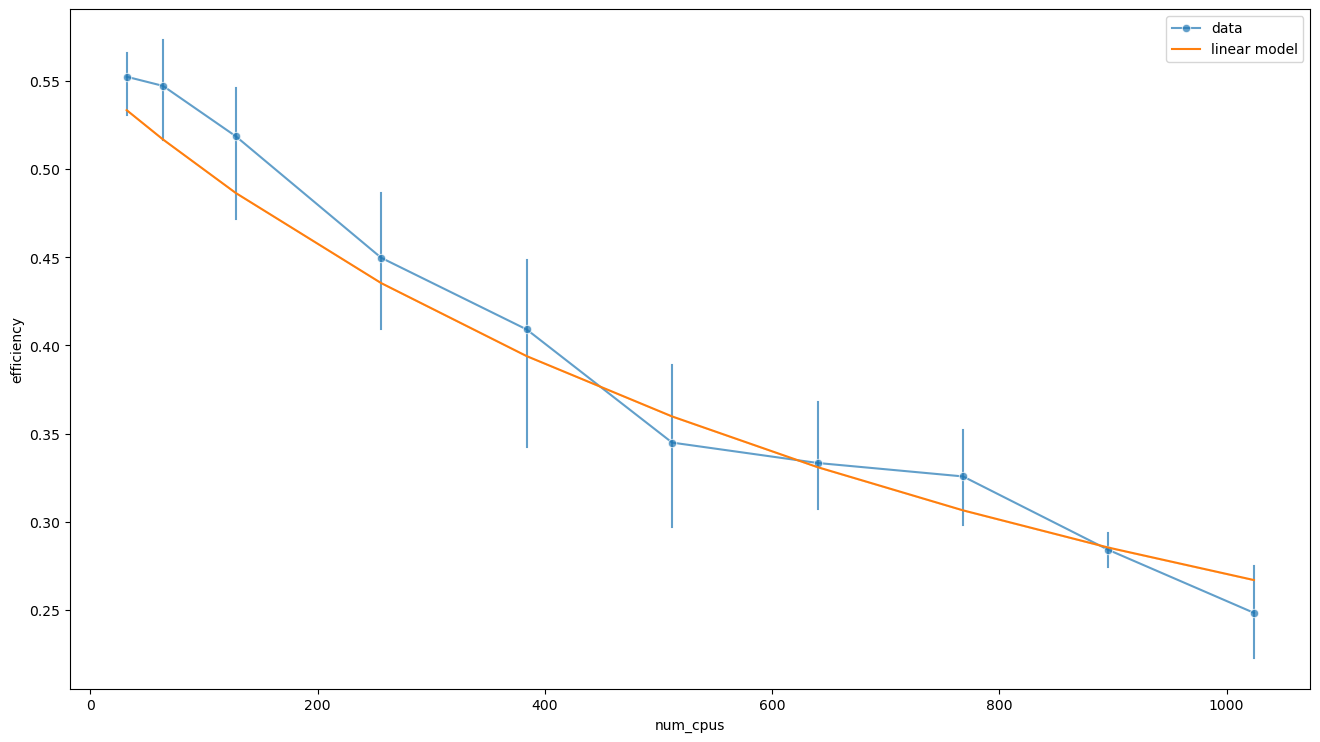

In [10]:
average_sample_duration = (data['good_samples_duration'] / data['num_good_samples']).mean()
predicted_efficiency = data['num_generations'] * average_sample_duration / (fit.params[1] + fit.params[0] * data['num_cpus'] / data['popsize'])
sns.lineplot(data=data, x='num_cpus', y='efficiency', alpha=0.7, marker='o', err_style='bars', label='data')
sns.lineplot(x=data['num_cpus'], y=predicted_efficiency, label='linear model')
plt.show()

The maximum efficiency is reached for $n \ll p$ and is equal to

$$\eta_\text{max} = \frac{g \langle t_\text{s} \rangle}{T_1} \, .$$

In [11]:
data['efficiency'].max(), (data['num_generations'] * data['good_samples_duration'] / data['num_good_samples']).mean() / fit.params[1]

(0.5730291571165904, 0.5510781335909407)

The story holds up: on the one hand, $g p T_1$ is the amount of work that can be split among workers, i.e. the average computation time times the budget. On the other, if we consider a serial execution with a large population (that is $n = 1$ and $p \gg 1$), then the efficiency is the ratio between the average time spent on a successful computation and the average computation time per unit budget $\langle t \rangle$. In both cases $T_1 = g \langle t \rangle$. Therefore, the maximum efficiency is $\eta_\text{max} = \frac{\langle t_\text{s} \rangle}{\langle t \rangle}$, and is characteristic of the objective function, the optimizer and the timeout.

Also, notice that there is an implicit dependency on $g$ in $T_1$, and hence in $\langle t \rangle$. Indeed, as the generations pass, the optimizer explores regions the search space associated to smaller and smaller losses, and it is plausible that the objective function fails less and less. Hence, the value of $\langle t \rangle$ calculated within a generation is expected to decrease from one generation to the next. In principle, there could be a also a dependency on $p$, but the data for large values of $p / n$ seems to exclude that (more on this topic in the next section).

Therefore, we can estimate $T_1$ from the data in this other way.

In [12]:
t1_estimate = (data['num_generations'] * data['samples_duration'] / data['num_good_samples']).mean()

fit.params[1], t1_estimate

(1546.7021007983863, 1216.4128161605433)

Notice that $\langle t \rangle$ can be larger than the timeout of the objective function. The reason is that there could be multiple failing computations per successful one.


## Models for Large $n$

The previous model fails to describe the situation for large $n$. The reason is that when $n$ is larger than the effective population size, adding more PUs should decrease sublinearly the execution time. Indeed, if we neglect the effects due to the statistics of successful computations, $T$ should be constant. For this reason, I considered other two models which introduce a scale $x_0$ for $p / n$ separating the two regimes.

The first one is a piecewise linear function

$$ T_\text{piecewise}(p, n) = \begin{cases} T_0 + T_1 \left( \frac{p}{n} - x_0 \right) & \text{if } \frac{p}{n} \geq x_0 \\ T_0 & \text{otherwise} \\ \end{cases} \, , $$

the other one is the lowest order rational function with vanishing slope at the origin and same asymptotic behaviour

$$ T_\text{rational}(p, n) = T_0 + T_1 \frac{x_0 \left(\frac{1}{x_0} \frac{p}{n}\right)^2}{1 + \frac{1}{x_0} \frac{p}{n}} \, .$$

We can fit the speedup using these models for the execution time. Since the speedup is defined as a ratio, it does not depend on the unit of measure of $T$. This also means that it is not a function of both $T_0$ and $T_1$ but depends only on their ratio. Since the behaviour we are trying to capture is at $p / n \to 0$, the three models are asymptotically equivalent, and the error on $T_1$ in the fit of the linear model is small, it is convenient to consider $T_1$ fixed to the previously calculated value.

We can now fit the piecewise model,

In [13]:
def speedup_from_t(t, n, params, p=512, n0=32):
    return t(np.asarray([p / n0]), *params) / t(p / n, *params)

def t_pwise(xs, t0, t1, x0):
    return np.apply_along_axis(lambda col: np.piecewise(col, [col >= x0, col < x0], [lambda x: t0 + t1 * (x - x0), t0]), 0, xs)

(t0_pwise, x0_pwise), cov = curve_fit(lambda x, t0, x0: speedup_from_t(t_pwise, x, [t0, fit.params[1], x0]),
                                              data['num_cpus'], data['speedup'])
(t0_pwise, x0_pwise), np.sqrt(np.diag(cov))

((1646.5908732589887, 0.5893299062130565), array([40.13697403,  0.04197212]))

and plot the results

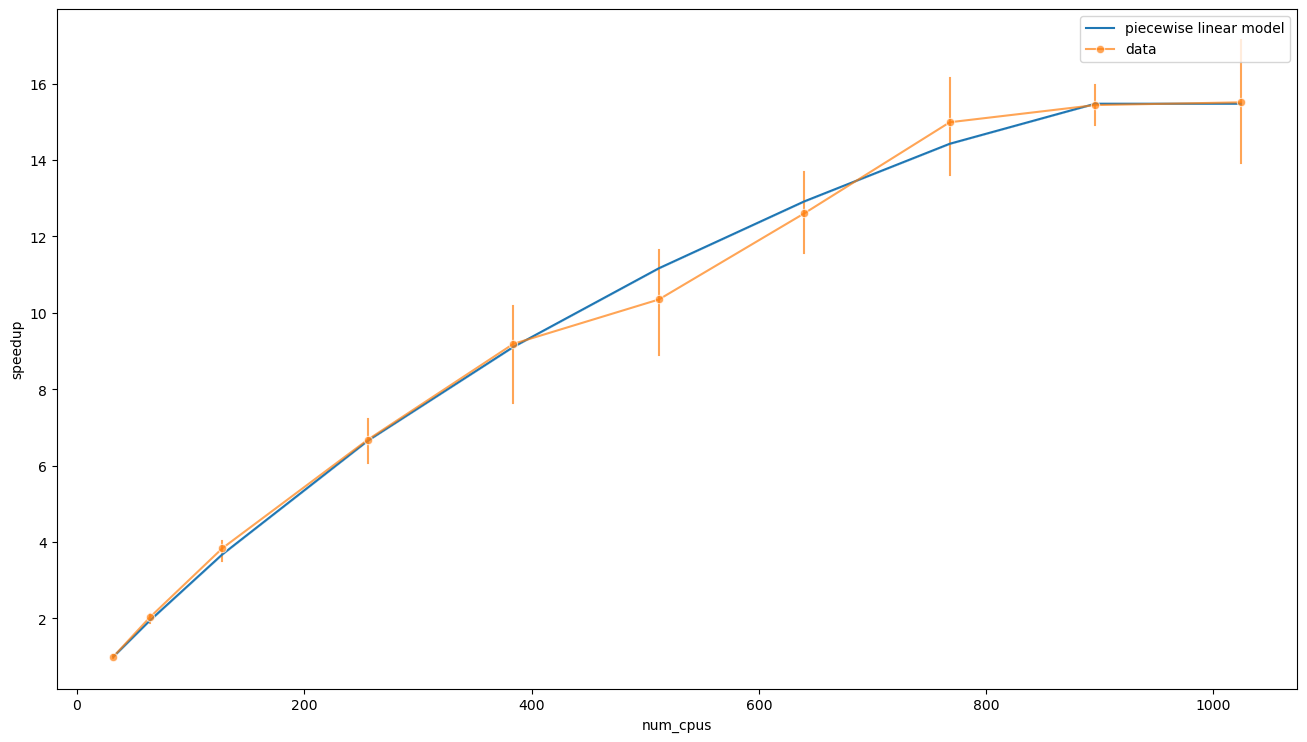

In [14]:
ax = sns.lineplot(x=data['num_cpus'], y=speedup_from_t(t_pwise, data['num_cpus'], [t0_pwise, fit.params[1], x0_pwise]), label='piecewise linear model')
sns.lineplot(data=data, x='num_cpus', y='speedup', alpha=0.7, marker='o', err_style='bars', label='data', ax=ax)
plt.show()

Visual inspection confirms that there is a good overlap between the data and this model. Indeed, there might even be overfitting. We can also interpret $T_0$ and $x_0$ and use their values to calculate the maximum speedup, which is

$$ S_\text{max, piecewise} = 1 + \frac{T_1}{T_0} \left( \frac{p}{n_0} - x_0 \right) \approx 15.5 \, .$$

This value is basically the average speedup at $n = 1024$.

The parameter $T_0$ is the lower bound for the execution time (i.e. when the work is split among infinite PUs), and the value of $T_0 \approx 27\text{m}$ is much more reasonable than $T_0 \approx 14\text{m}$ found in the linear model. Indeed, in the limit $p / n \to 0$, we can estimate this parameter

$$T_0 \approx g \langle t_\text{s} \rangle + \Delta T_0$$

where $\Delta T_0$ is the amount of time needed by the system and the optimizer. We can calculate this number using the available data

In [15]:
t0_pwise - (data['num_generations'] * data['good_samples_duration'] / data['num_good_samples']).mean()

794.237166329827

that is $\Delta T_0 \approx 13\text{m}$.

It is also interesting to explicit the meaning of $x_0$. In the piecewise model this parameter is the value of $p / n$ at which the time abruptly stops scaling: this means that the number of PUs has exceded the effective population, hence

$$ p_\text{eff} \approx \frac{p}{x_0} \approx 868 \, .$$

This value is also the optimal number of PUs.

We can fit in the same way the rational model

In [16]:
def t_rat(x, t0, t1, x0):
    return t0 + t1 * x0 * (x / x0) ** 2 / (1 + (x / x0))


(t0_rat, x0_rat), cov = curve_fit(lambda x, t0, x0: speedup_from_t(t_rat, x, [t0, fit.params[1], x0]),
                                            data['num_cpus'], data['speedup'], bounds=(0.0, np.inf))
(t0_rat, x0_rat), np.sqrt(np.diag(cov))

((1109.9192294187324, 0.32353410232671953),
 array([192.64967956,   0.31587426]))

plot the result

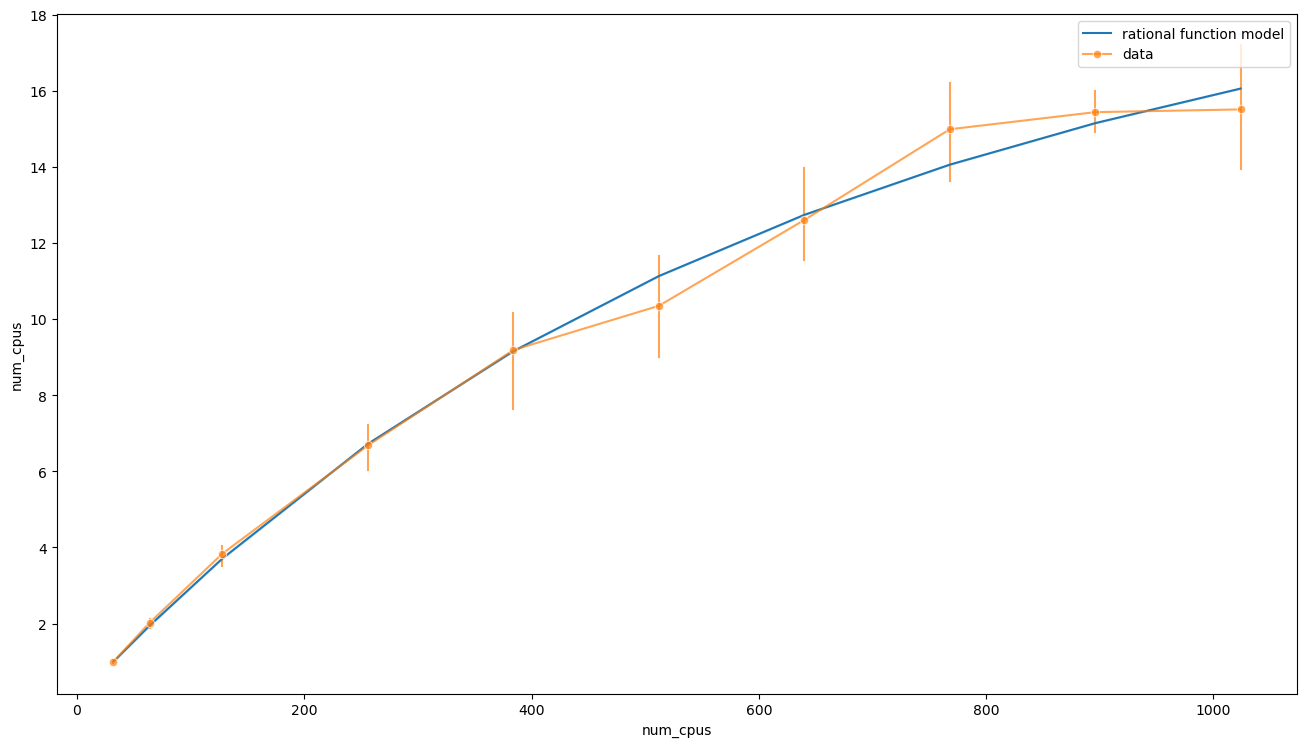

In [17]:
ax = sns.lineplot(x=data['num_cpus'], y=speedup_from_t(t_rat, data['num_cpus'], [t0_rat, fit.params[1], x0_rat]), label='rational function model')
sns.lineplot(data=data, x='num_cpus', y='speedup', alpha=0.7, marker='o', err_style='bars', label='data', ax=ax)
plt.show()

and see that the behaviour at large $n$ is quite different. In this case we have

$$ S_\text{max, rational} = 1 + \frac{T_1}{T_0} \frac{x_0 \left( \frac{1}{x_0} \frac{p}{n_0} \right)^2}{ 1 + \frac{1}{x_0} \frac{p}{n_0} } \approx 23 \, .$$

Using the previous argument (although it is a bit of a stretch) we can also estimate the order of magnitude of $p_\text{eff}$

$$p_\text{eff} \approx \frac{p}{x_0} \approx 1600 \, . $$

Also, in this case, the estimated serial time

In [18]:
t0_rat - (data['num_generations'] * data['good_samples_duration'] / data['num_good_samples']).mean()

257.56552248957064

is much less, $\Delta T \approx 4\text{m}$.

All in all, the piecewise linear model seems to be a bit more realistic.

Finally, it is instructive to take a look at the different models for execution times near $p / n \to 0$

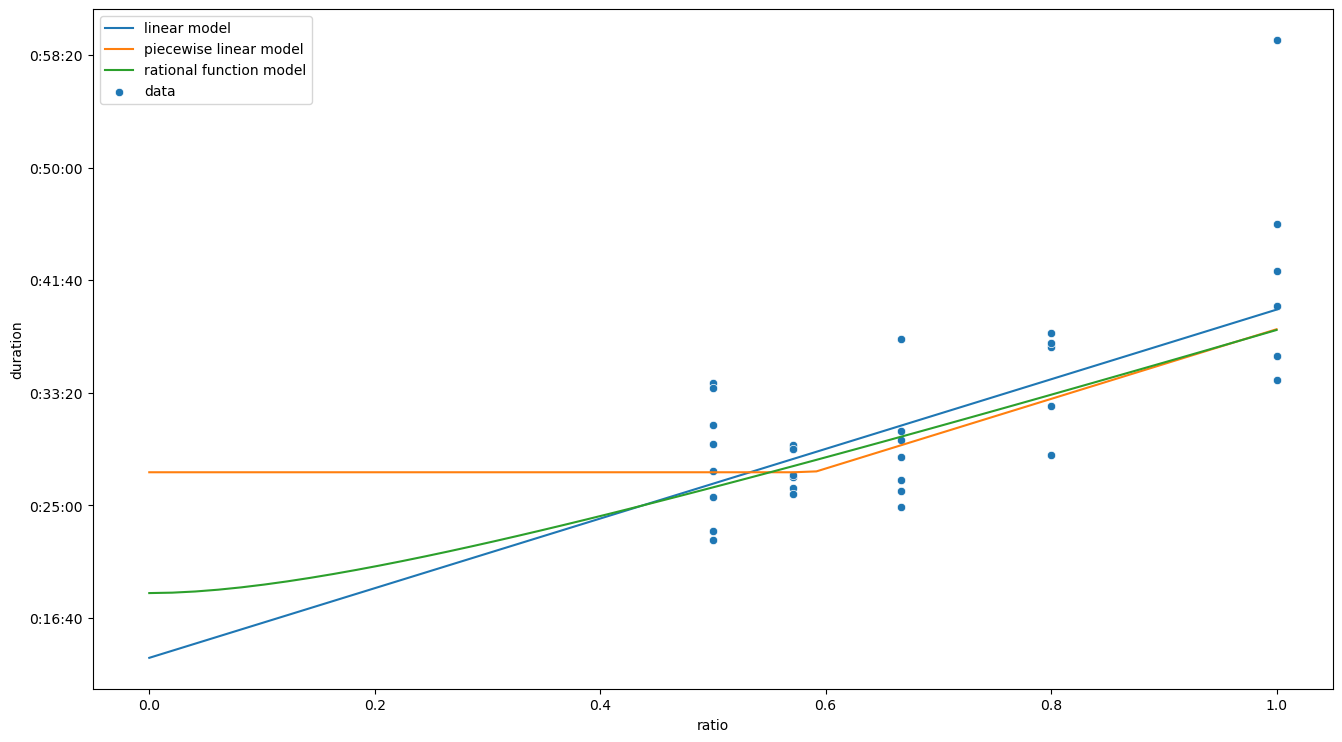

In [19]:
xs = np.linspace(0, 1)
ax = sns.scatterplot(data=data[data['ratio'] <= 1.0], x='ratio', y='duration', estimator=np.mean, label='data')
sns.lineplot(x=xs, y=fit.params[0] + fit.params[1] * xs, label='linear model', ax=ax)
sns.lineplot(x=xs, y=t_pwise(xs, t0_pwise, fit.params[1], x0_pwise), label='piecewise linear model', ax=ax)
sns.lineplot(x=xs, y=t_rat(xs, t0_rat, fit.params[1], x0_rat), label='rational function model', ax=ax)
ax.yaxis.set_major_formatter(lambda value, position: timedelta(seconds=value))
plt.show()

or equivalently to the speedups at $n \gg p$

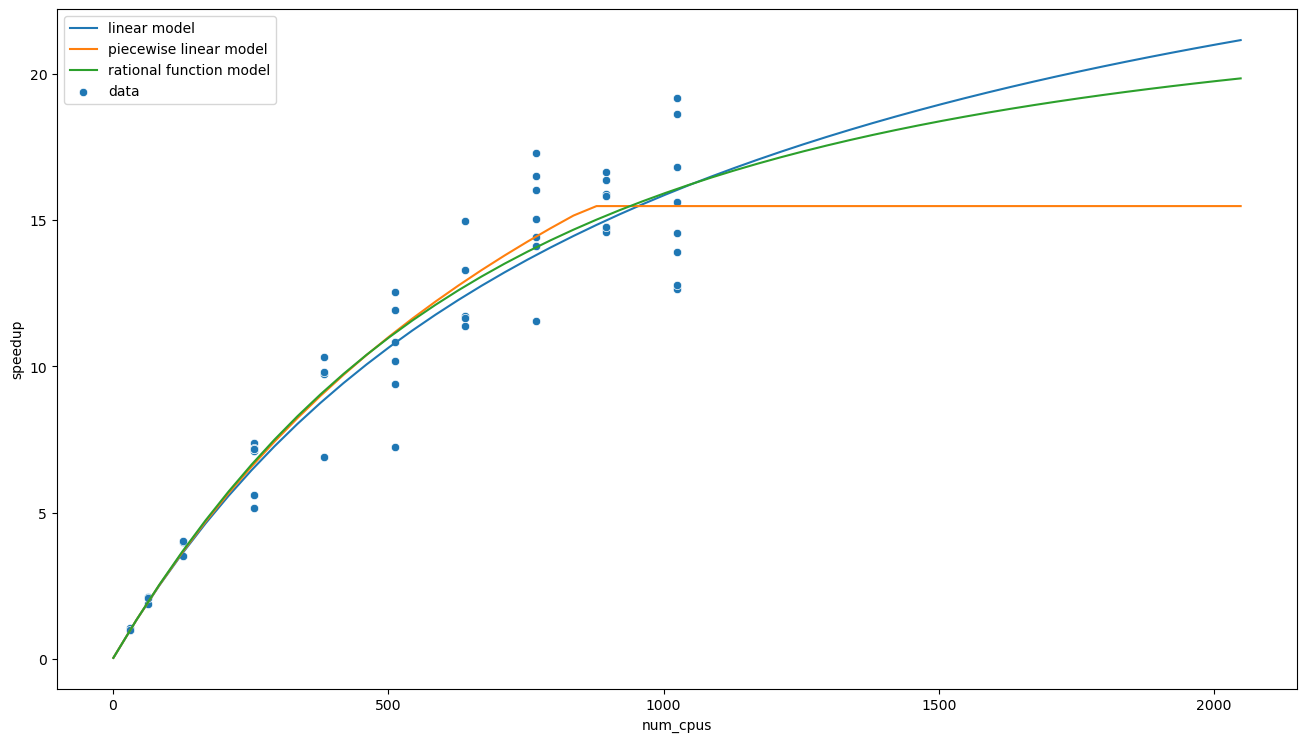

In [20]:
xs = np.linspace(1,2048)
ax = sns.scatterplot(data=data, x='num_cpus', y='speedup', estimator=np.mean, label='data')
sns.lineplot(x=xs, y=speedup_from_t(lambda x, t0, t1: t0 + t1 * x, xs, fit.params), label='linear model', ax=ax)
sns.lineplot(x=xs, y=speedup_from_t(t_pwise, xs, [t0_pwise, fit.params[1], x0_pwise]), label='piecewise linear model', ax=ax)
sns.lineplot(x=xs, y=speedup_from_t(t_rat, xs, [t0_rat, fit.params[1], x0_rat]), label='rational function model', ax=ax)
plt.show()
